In [ ]:
import json
import torch
import numpy as np
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import InterpolationMode

import sys
from pathlib import Path

notebook_path = Path().resolve()
project_root = notebook_path.parent
sys.path.append(str(project_root))

from utils import ImagePromptDataset

c:\Users\wolfg\OneDrive\Documents\Projects\OMI-Training-Pipeline\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Test DataLoader and Image Class

In [2]:
# dataset = load_dataset("openmodelinitiative/initial-test-dataset")
# dataset = load_dataset("laion/laion2B-en")
# data_id = "idning/ffhq64-caption"
# data_id = "idning/ffhq128-caption"
data_id= "pcuenq/lsun-bedrooms"

ds = load_dataset(data_id)

#to run on runpod I had to comment out lines 188/189 in usr/lib/local/pyhton/datasets/features/Image.py 

# ds = load_dataset("pcuenq/lsun-bedrooms")
split_ds = ds['train'].train_test_split(test_size=0.1, seed=42)


In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=InterpolationMode.LANCZOS),
    transforms.ToTensor(),  # Converts to tensor and scales pixel values to [0, 1]
])

In [4]:
# Create the custom dataset
train_dataset = ImagePromptDataset(split_ds["train"], transform=transform, device = torch.device('cuda'), maps = ['depth','edge'])
val_dataset = ImagePromptDataset(split_ds["test"], transform=transform , device = torch.device('cuda'), maps = ['depth', 'edge'])   


Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\wolfg\OneDrive\Documents\Projects\OMI-Training-Pipeline\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master


In [5]:
sample = train_dataset[0]

c:\Users\wolfg\OneDrive\Documents\Projects\OMI-Training-Pipeline\.venv\Lib\site-packages\timm\models\vision_transformer.py:93: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


In [6]:
sample[0].shape

torch.Size([3, 64, 64])

In [7]:
print(sample[-1].shape)

torch.Size([2, 64, 64])


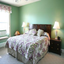

In [8]:
transforms.ToPILImage()(sample[0])

In [33]:
# Training DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=0  # Set to 0 if you encounter issues on Windows
)

# Validation DataLoader
val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0
)

In [34]:
next(iter(train_dataloader))

[tensor([[[[0.0863, 0.0941, 0.0941,  ..., 0.9647, 0.3804, 0.1333],
           [0.0941, 0.0941, 0.0941,  ..., 0.9608, 0.3529, 0.1451],
           [0.0980, 0.0902, 0.0902,  ..., 0.9176, 0.3098, 0.1490],
           ...,
           [0.2784, 0.2863, 0.2941,  ..., 0.0627, 0.0627, 0.0667],
           [0.2784, 0.2863, 0.2941,  ..., 0.0627, 0.0588, 0.0667],
           [0.2902, 0.2980, 0.3020,  ..., 0.0588, 0.0588, 0.0667]],
 
          [[0.0667, 0.0745, 0.0784,  ..., 0.9647, 0.3647, 0.1294],
           [0.0745, 0.0745, 0.0784,  ..., 0.9569, 0.3412, 0.1412],
           [0.0784, 0.0706, 0.0784,  ..., 0.9137, 0.3020, 0.1412],
           ...,
           [0.1412, 0.1490, 0.1569,  ..., 0.0627, 0.0588, 0.0627],
           [0.1412, 0.1490, 0.1608,  ..., 0.0627, 0.0549, 0.0627],
           [0.1529, 0.1608, 0.1647,  ..., 0.0588, 0.0549, 0.0627]],
 
          [[0.0510, 0.0588, 0.0627,  ..., 0.9490, 0.3647, 0.1098],
           [0.0588, 0.0588, 0.0627,  ..., 0.9608, 0.3176, 0.1176],
           [0.0627, 0.05

In [35]:
from transformers import AutoTokenizer, T5EncoderModel

In [36]:
tokenizer = AutoTokenizer.from_pretrained('../components/t5Base')
text_encoder = T5EncoderModel.from_pretrained('../components/t5Base')

text_encoder.to(torch.device('cuda'))

T5EncoderModel(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dropout(p=0.1, 

In [37]:
def encode_text(text):
    tokens = tokenizer(text, padding=True, max_length= 128, truncation=True, return_tensors="pt").to( torch.device('cuda'))
    with torch.no_grad():
        text_embeddings = text_encoder(tokens.input_ids)[0]
    return text_embeddings


In [38]:
from utils import ControlTransformer, MapEncoder

In [39]:
con_tran = ControlTransformer()
con_tran.to(torch.device('cuda'))

ControlTransformer(
  (map_encoder): MapEncoder(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(128, 768, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU(inplace=True)
    )
  )
  (layers): ModuleList(
    (0-3): 4 x TransformerLayer(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=768, out_features=2048, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=2048, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

## Test a single sample


In [40]:
text_embeddings = encode_text('A bedroom with some windows',
                              )
control_maps = sample[-1]

In [41]:
text_embeddings.shape, control_maps.shape

(torch.Size([1, 6, 768]), torch.Size([2, 64, 64]))

In [42]:
control_embeddings = con_tran(text_embeddings, control_maps.unsqueeze(0))

In [43]:
control_embeddings.shape

torch.Size([1, 2, 768])

## Test a batch of 2

In [48]:
batch_2 = next(iter(train_dataloader))
imgs = batch_2[0].shape
prompts = batch_2[1]
maps = batch_2[-1]

In [52]:
prompts = ['A bedroom with some windows', 'A bedroom with a bed and a window'] #the lshun dataset has no prompts... we'll make some for this use case

In [53]:
text_embeddings = encode_text(prompts)
print(text_embeddings.shape)

torch.Size([2, 11, 768])


In [54]:
control_embeddings = con_tran(text_embeddings, maps)

In [55]:
control_embeddings.shape

torch.Size([2, 2, 768])

## Test a batch of 4

In [57]:
batch_4 = next(iter(val_dataloader))

imgs = batch_4[0].shape
prompts = batch_4[1]
maps = batch_4[-1]

In [58]:
prompts = ['A bedroom with some windows',
           'A bedroom with a bed and a window',
           "a bedroom with a charming style",
           "a bedroom with a chair"] 
#the lshun dataset has no prompts... we'll make some for this use case


In [59]:
text_embeddings = encode_text(prompts)
print(text_embeddings.shape)

torch.Size([4, 11, 768])


In [60]:
control_embeddings = con_tran(text_embeddings, maps)
control_embeddings.shape


torch.Size([4, 2, 768])